# Iceberg Demo

Sample fragmentation

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import ms_pred.magma.fragmentation as fe
from ms_pred.common.plot_utils import *
from ms_pred.dag_pred import joint_model

set_style()


%load_ext autoreload
%autoreload 2

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def draw_single_mol(frag, engine):
    """Draw single molecule."""
    draw_dict = engine.get_draw_dict(frag)
    keep_atoms = draw_dict['hatoms']
    keep_bonds = draw_dict['hbonds']
    mol = draw_dict['mol']
    # print(keep_atoms, keep_bonds)
    Chem.Kekulize(mol)
    drawing = Draw.MolToImage(mol,highlightAtoms=keep_atoms, highlightBonds=keep_bonds)
    return drawing

Get single example from NIST20


In [10]:
sample_labels = "../data/spec_datasets/sample_labels.tsv"
test_df = pd.read_csv(sample_labels, sep="\t")

# Get first entry from test_df for smiles and ionization
test_smiles = test_df.iloc[0]['smiles']
test_ionization = test_df.iloc[0]['ionization']

test_smiles = "InChI=1S/C7H15NO3/c1-8(2,3)5-6(9)4-7(10)11/h6,9H,4-5H2,1-3H3/p+1"
test_smiles = "C[N+](C)(C)CC(CC(=O)O)O"
test_ionization = "[M+H]+"

Load models (run quickstart/iceberg/download_models.sh first to download)

In [11]:
# Get best models
inten_ckpt = f"../quickstart/iceberg/models/canopus_iceberg_score.ckpt"
gen_ckpt = f"../quickstart/iceberg/models/canopus_iceberg_generate.ckpt"

# Load joint model
model = joint_model.JointModel.from_checkpoints(inten_checkpoint=inten_ckpt,
                                                gen_checkpoint=gen_ckpt)



In [13]:
# Predict example entry
# Model predict takes both a smiles string and an ionization
outputs = model.predict_mol(smi=test_smiles,
                            adduct=test_ionization,
                            device="cpu",
                            max_nodes=100,
                            binned_out=False,
                            threshold=0)

The model output will contain 3 keys: "root_inchi", "name", and "frags"

1. root_inchi: Root inchi string
2. name: Often empty string used to specify a spectrum input
3. frags: Dictionary containing the predicted fragments

In particular, frags has keys corresponding to hash IDs of each subfragment, mapped to the intensities predicted at that value. Each value (outputs['frags']['key']) is itself a dictionary with the following keys:

1. frag: A binary representation corresponding to which atoms are present in the substructure
2. frag_hash: Unique hash of the substructure
3. parents: hash ids of the parent fragments in the predicted DAG
4. mz_no_charge: a list of mass values corresponding to various hydrogen rearrangements _less_ the mz of the precursor adduct
5. mz_charge: equivalent to mz_no_charge but adding the precursor adduct
6. intens: predicted intensity at each mz value
7. form: Molecular formula

In addition, for completeness, the following additional keys are also included:

8. atoms_pulled: Defines which atoms were removed from the molecule in the tree (can be ignored)
9. left_pred: Defines predictions at each of the atoms for their probability of leaving
10. max_broken: This defines how many bonds were broken in the DAG to reach the fragment of interest, which influences masking during generation
11. tree_depth: Tree depth on the DAG
12. id: A shorter ID not used elsewhere
13. prob_gen: The probability of observing this subfragment according to the first model
14. score: The score that the MAGMa heuristic applies to this fragment
15. frag_hs: The total number of hydrogens attached to the original fragment
16. max_remove_hs: maximum number of hs to remove
17. max_add_hs: Max hs to add

Below we show how to identify the fragments and plot the outputs

Binary repr of fragmentation number: 182


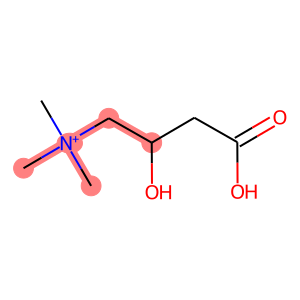

In [14]:
root_inchi = outputs['root_inchi']
frags = outputs['frags']

# Generate a fragmentation engine
engine = fe.FragmentEngine(mol_str=root_inchi, mol_str_type="inchi")

# Select a random fragment index to draw
frag_dicts = list(frags.items())
random_frag_ind = np.random.choice(len(frag_dicts))
random_frag = frag_dicts[random_frag_ind]

# Get "frag" the binary representation of which atoms are present and draw it
frag_num = random_frag[1]['frag']
print(f"Binary repr of fragmentation number: {frag_num}")
draw_single_mol(frag_num, engine)

Below we show how to sum all intensities according to mz in order to generate a single spectrum

In [15]:
# Convert from frags dict into a list of mz, inten
mass_to_obj = defaultdict(lambda: {})
for k, val in frags.items():
    masses, intens = val["mz_charge"], val['intens']
    for m, i in zip(masses, intens):
        if i <= 0:
            continue
        cur_obj = mass_to_obj[m]
        if cur_obj.get("inten", 0) > 0:
            # update
            if cur_obj.get("inten") < i:
                cur_obj["frag_hash"] = k
            cur_obj["inten"] += i
        else:
            cur_obj["inten"] = i
            cur_obj["frag_hash"] = k

max_inten = max(*[i["inten"] for i in mass_to_obj.values()], 1e-9)
mass_to_obj = {
    k: dict(inten=v["inten"] / max_inten, frag_hash=v["frag_hash"])
    for k, v in mass_to_obj.items()
}

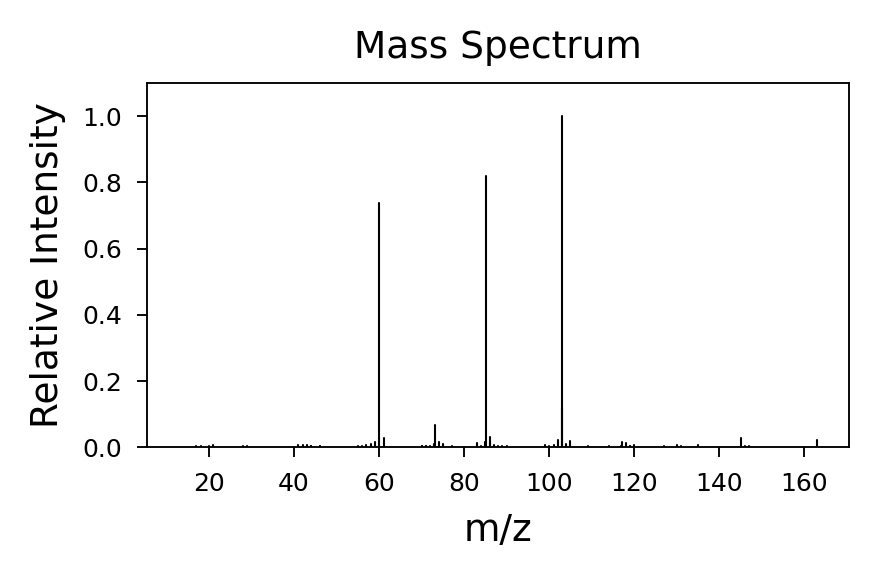

In [16]:
# Plot the output
fig = plt.figure(figsize=(3,2), dpi=300)
for k, v in mass_to_obj.items():
    # Plot verticle line from k to v['inten']
    plt.plot([k, k], [0, v['inten']], color='black', linewidth=0.5)
    # Can also get the frag id if we want to plot one of these in particular

plt.xlabel("m/z")
plt.ylabel("Relative Intensity")
plt.title("Mass Spectrum")
# Set ylim 
plt.ylim(0, 1.1)
plt.tight_layout()